In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from itertools import product

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [2]:
# Read in 
df10 = pd.read_csv('../data/df10.csv')

In [3]:
# Inspect
df10

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,y
0,0.611402,0.720283,3.165168,0.372100,-0.360194,6.417779,A2,B3,C16,D1,-16.680112
1,-0.463374,-0.908280,3.046919,0.866590,0.949304,6.142320,A1,B2,C6,D3,-0.347247
2,-0.004264,-2.710478,3.629876,0.587660,-0.413790,7.196720,A2,B1,C10,D3,-13.192616
3,0.310406,-0.511657,3.269785,3.036609,-0.430169,6.363889,A2,B5,C33,D2,0.764504
4,-2.537362,0.594968,1.731083,0.616347,1.753629,3.273066,A1,B1,C6,D3,1.757865
...,...,...,...,...,...,...,...,...,...,...,...
9995,0.786519,-0.053336,4.551310,0.503011,-0.332187,8.955659,A2,B4,C48,D2,-5.785166
9996,-3.341972,-0.603921,2.693938,-0.788320,-0.766215,5.303121,A1,B5,C24,D2,19.692702
9997,-0.409354,0.337466,3.140098,-1.672133,-0.235241,5.997826,A1,B1,C32,D3,-0.011697
9998,-2.129938,-0.588379,3.735092,-0.368141,1.876631,7.281910,A2,B1,C16,D3,-17.691367


In [4]:
# Set random seed
np.random.seed(666)

# First attempt

- Ignore x9
- 60/20/20 train/test/holdout [6k/2k/2k rows]
- Within train, 6-fold cross-validation to optimize hyperparameters:
    - `max_depth` = 2-8
    - `max_features` = 'auto', 'sqrt', 'log2'
    - `subsample` = 0.5, 0.67, 0.75
    - Static parameters
        - `n_estimators` = 1k
        - `validation_fraction` = 0.2
        - `n_iter_no_change` = 1
        - `tol` = 1e-4
        
Also, will not include x3 and x6 because they were not found to have much relationship with y.

In [5]:
# Train/test/holdout vars
p_train = 0.6
p_test = 0.2
p_test_relative = p_test / (p_train + p_test)
p_holdout = 0.2
k_folds = 6

# Static hyperparameters
s_n_estimators = 1000
s_validation_fraction = 0.2
s_n_iter_no_change = 1
s_tol = 1e-4

# Lists of hyperparameters to optimize
l_max_depth = [2, 3, 4, 5, 6, 7, 8]
l_max_features = ['auto', 'sqrt', 'log2']
l_subsample = [0.5, 0.67, 0.75]

In [6]:
# Add some x2 predictors
df10['x2_abs'] = abs(df10['x2'])
df10['x2_sign'] = np.sign(df10['x2'])

# Create X/y
predictors_1 = ['x1', 'x2', 'x2_abs', 'x2_sign', 'x4', 'x5', 'x7', 'x8', 'x10']
X, y = pd.get_dummies(df10[predictors_1], prefix=['x7', 'x8', 'x10']), df10['y']

# Split train/test/holdout
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=p_holdout, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=p_test_relative, random_state=2)

# Check counts
print(f'''
Train: {X_train.shape}
Test: {X_test.shape}
Holdout: {X_holdout.shape}
''')


Train: (6000, 16)
Test: (2000, 16)
Holdout: (2000, 16)



In [7]:
# How many iterations of cross-validation?
hp_sets = list(product(l_max_depth, l_max_features, l_subsample))

len(hp_sets)

63

In [8]:
scores_1 = []
for md, mf, ss in hp_sets:
    # Print status
    print(f'Fitting max_depth={md}, max_features={mf}, subsample={ss}')
    
    # Initialize gbm
    gbm = GradientBoostingRegressor(
        # Static hyperparameters
        n_estimators = s_n_estimators,
        validation_fraction = s_validation_fraction,
        n_iter_no_change = s_n_iter_no_change,
        tol = s_tol,
        # Dynamic hyperparameters
        max_depth = md,
        max_features = mf,
        subsample = ss,
    )

    # Get scores
    cv_score = cross_val_score(
        gbm,
        X_train,
        y_train,
        cv = k_folds,
        scoring = 'neg_mean_squared_error',
        n_jobs = -1
    ) 

    # Save the score means and standard deviations
    for i, k in enumerate(cv_score):
        scores_1 += [((md, mf, ss), i, k, np.mean(cv_score))]
    
    del gbm, cv_score

Fitting max_depth=2, max_features=auto, subsample=0.5
Fitting max_depth=2, max_features=auto, subsample=0.67
Fitting max_depth=2, max_features=auto, subsample=0.75
Fitting max_depth=2, max_features=sqrt, subsample=0.5
Fitting max_depth=2, max_features=sqrt, subsample=0.67
Fitting max_depth=2, max_features=sqrt, subsample=0.75
Fitting max_depth=2, max_features=log2, subsample=0.5
Fitting max_depth=2, max_features=log2, subsample=0.67
Fitting max_depth=2, max_features=log2, subsample=0.75
Fitting max_depth=3, max_features=auto, subsample=0.5
Fitting max_depth=3, max_features=auto, subsample=0.67
Fitting max_depth=3, max_features=auto, subsample=0.75
Fitting max_depth=3, max_features=sqrt, subsample=0.5
Fitting max_depth=3, max_features=sqrt, subsample=0.67
Fitting max_depth=3, max_features=sqrt, subsample=0.75
Fitting max_depth=3, max_features=log2, subsample=0.5
Fitting max_depth=3, max_features=log2, subsample=0.67
Fitting max_depth=3, max_features=log2, subsample=0.75
Fitting max_dept

In [9]:
# Save results as a dataframe
scores_1_df = pd.DataFrame(
    scores_1,
    columns = ['hp', 'k', 'score_k', 'score_hp_mean']
)

# Order by score_hp_mean and k
scores_1_df = scores_1_df.sort_values(['score_hp_mean', 'k'], ascending=[False, True]).reset_index()

scores_1_df.head(20)

,index,hp,k,score_k,score_hp_mean
0,66,"(3, auto, 0.75)",0,-60.480863,-61.855888
1,67,"(3, auto, 0.75)",1,-60.245512,-61.855888
2,68,"(3, auto, 0.75)",2,-63.793966,-61.855888
3,69,"(3, auto, 0.75)",3,-58.387193,-61.855888
4,70,"(3, auto, 0.75)",4,-64.107602,-61.855888
5,71,"(3, auto, 0.75)",5,-64.120191,-61.855888
6,114,"(4, auto, 0.67)",0,-59.088607,-62.070352
7,115,"(4, auto, 0.67)",1,-60.676768,-62.070352
8,116,"(4, auto, 0.67)",2,-65.262020,-62.070352
9,117,"(4, auto, 0.67)",3,-58.849299,-62.070352


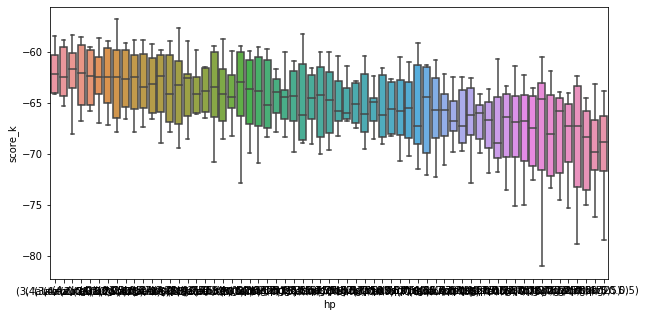

In [10]:
# Boxplot of performance for each parameter set
plt.figure(figsize=(10, 5))
sb.boxplot(
    data = scores_1_df,
    x = 'hp',
    y = 'score_k',
)

In [11]:
# Hyperparameter sets in order
scores_1_df.hp.unique()

array([(3, 'auto', 0.75), (4, 'auto', 0.67), (3, 'auto', 0.67),
       (4, 'auto', 0.75), (4, 'log2', 0.75), (2, 'auto', 0.67),
       (3, 'auto', 0.5), (4, 'log2', 0.67), (5, 'auto', 0.5),
       (2, 'auto', 0.5), (3, 'log2', 0.75), (4, 'auto', 0.5),
       (2, 'auto', 0.75), (5, 'log2', 0.75), (4, 'sqrt', 0.75),
       (4, 'log2', 0.5), (6, 'auto', 0.5), (6, 'auto', 0.67),
       (5, 'auto', 0.67), (6, 'auto', 0.75), (4, 'sqrt', 0.67),
       (5, 'log2', 0.67), (4, 'sqrt', 0.5), (5, 'auto', 0.75),
       (5, 'log2', 0.5), (3, 'sqrt', 0.5), (3, 'log2', 0.5),
       (6, 'log2', 0.75), (3, 'sqrt', 0.75), (7, 'auto', 0.5),
       (5, 'sqrt', 0.67), (3, 'log2', 0.67), (5, 'sqrt', 0.75),
       (6, 'log2', 0.5), (7, 'auto', 0.67), (7, 'log2', 0.75),
       (3, 'sqrt', 0.67), (6, 'sqrt', 0.75), (8, 'auto', 0.67),
       (5, 'sqrt', 0.5), (6, 'sqrt', 0.67), (2, 'sqrt', 0.67),
       (6, 'log2', 0.67), (7, 'auto', 0.75), (8, 'auto', 0.5),
       (6, 'sqrt', 0.5), (8, 'sqrt', 0.75), (7, 'sqrt'

Quite a few of the unique combinations at the beginning are very similar and have rather similar distributional behavior in the boxplot.  In absense of a clear winner, let's proceed with the following parameter sets to provide some variety in models that may fit well on the test set.

- (3, 'auto', 0.75)  # Best overall performance
- (2, 'auto', 0.75)  # Best 2 depth performance
- (4, 'auto', 0.75)  # Best 4 depth performance
- (6, 'auto', 0.75)  # Best 6 depth performance
- (3, 'log2', 0.67)  # Best log2 performance
- (4, 'sqrt', 0.5)  # Best sqrt performance

In [12]:
# Fit new models on whole training data set
best_hp_sets = [
    (3, 'auto', 0.75),
    (2, 'auto', 0.75),
    (4, 'auto', 0.75),
    (6, 'auto', 0.75),
    (3, 'log2', 0.67),
    (4, 'sqrt', 0.5),
]
models_train_1 = {}

for hp in best_hp_sets:
    print(f'Fitting {hp}')
    
    # Fit gbm
    gbm = GradientBoostingRegressor(
        # Static hyperparameters
        n_estimators = s_n_estimators,
        validation_fraction = s_validation_fraction,
        n_iter_no_change = s_n_iter_no_change,
        tol = s_tol,
        # Dynamic hyperparameters
        max_depth = hp[0],
        max_features = hp[1],
        subsample = hp[2],
        # Print status
        verbose = 1
    ).fit(X_train, y_train)
    
    # Save predictions
    models_train_1[hp] = {
        'model': gbm,
        'train_err': y_train - gbm.predict(X_train),
        'test_err': y_test - gbm.predict(X_test)
    }
    
    del gbm

Fitting (3, 'auto', 0.75)
      Iter       Train Loss      OOB Improve   Remaining Time 
         1         188.3604          22.2521            5.99s
         2         161.1904          20.8613            6.99s
         3         154.5030          13.7389            6.98s
         4         135.3511          13.0265            6.72s
         5         127.4882           9.2971            6.77s
         6         119.7117           7.8903            6.79s
         7         110.5826           6.6609            6.81s
         8         106.7489           5.4957            6.70s
         9          99.3549           4.8446            6.61s
        10          95.2486           3.4564            6.63s
        20          75.4625           0.8525            6.32s
        30          65.4856           0.6876            6.18s
        40          60.5690           0.1650            6.14s
        50          57.9753           0.0975            6.04s
        60          55.8284           0.009

In [13]:
# Inspect one model
models_train_1[best_hp_sets[0]]

{'model': GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                           init=None, learning_rate=0.1, loss='ls', max_depth=3,
                           max_features='auto', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=1000,
                           n_iter_no_change=1, presort='deprecated',
                           random_state=None, subsample=0.75, tol=0.0001,
                           validation_fraction=0.2, verbose=1, warm_start=False),
 'train_err': 7820    10.064575
 5815     9.481590
 7309     0.469405
 7163     8.744251
 2674     5.849403
           ...    
 9907     3.154354
 485     11.788663
 264     -4.493576
 8577     9.022147
 6415    -5.346289
 Name: y, Length: 6000, dtype: float64,
 'test_err': 369      5.392732
 2608     7.546707
 2

In [14]:
# Compare average mean squared errors
def amse(err):
    return (err ** 2).sum() / len(err)

for hp in best_hp_sets:
    print(f'''{hp}
    Train error: {amse(models_train_1[hp]['train_err'])}
    Test error: {amse(models_train_1[hp]['test_err'])}
    ''')

(3, 'auto', 0.75)
    Train error: 56.49459523613887
    Test error: 61.93190010014272
    
(2, 'auto', 0.75)
    Train error: 58.611331821641905
    Test error: 61.902461369996615
    
(4, 'auto', 0.75)
    Train error: 55.859258527690834
    Test error: 62.16049740306054
    
(6, 'auto', 0.75)
    Train error: 48.48623107448711
    Test error: 62.81965300418269
    
(3, 'log2', 0.67)
    Train error: 60.72342809247705
    Test error: 64.8559763977514
    
(4, 'sqrt', 0.5)
    Train error: 56.48581236449429
    Test error: 64.09933074376158
    


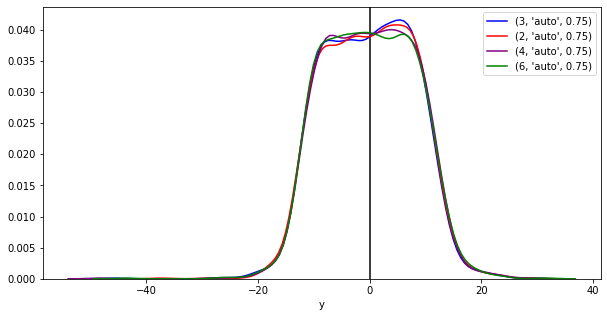

In [15]:
# Plot error distributions on test data for the better models
plt.figure(figsize=(10, 5))
plt.axvline(0, color='black')
colors = ['blue', 'red', 'purple', 'green']
models_to_plot = best_hp_sets[:4]
for i, hp in enumerate(models_to_plot):
    sb.distplot(models_train_1[hp]['test_err'], hist=False, color=colors[i], label=hp)

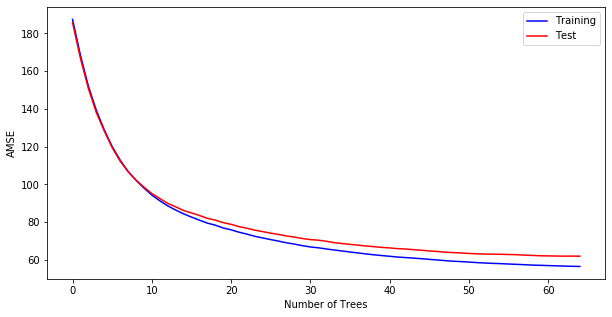

In [16]:
# Learning curves
def plot_lc(model):
    lc_train = [amse(y_train - x) for x in models_train_1[model]['model'].staged_predict(X_train)]
    lc_test = [amse(y_test - x) for x in models_train_1[model]['model'].staged_predict(X_test)]
    lc_x = list(range(len(lc_train)))

    plt.figure(figsize=(10, 5))
    sb.lineplot(x=lc_x, y=lc_train, color='blue', label='Training')
    sb.lineplot(x=lc_x, y=lc_test, color='red', label='Test')
    plt.xlabel('Number of Trees')
    plt.ylabel('AMSE')

# "Best" model
plot_lc(best_hp_sets[0])

All of the 'auto' models look similar on the test data but have rather different performance on the training data.

We'll gloss over that for now to see how x9 changes things.

# Now incorporate x9

x9 presents a unique problem with cross-validation.

Say we wanted to replace x9 with its group average.  If we use the averages over the **whole** training set, we introduce signal leakage in the folds being held out for test predictions (i.e. we're using the target variable in folds we're trying to predict to create predictors).  So if we really wanted to pair that with cross-validation to estimate hyperparameters we need to write custom code to derive that new `x9_group_mean` variable separately for each of the k iterations before fitting.  Which is possible but didn't want to go through that process here.

For simplicity, let's say we feel comfortable assuming that we only need to consider our current "best" sets of hyperparameters and evaluate using train/test splitting (i.e. use `hp_sets`).

In [17]:
X_train

,x1,x2,x2_abs,x2_sign,x4,x5,x7_A1,x7_A2,x8_B1,x8_B2,x8_B3,x8_B4,x8_B5,x10_D1,x10_D2,x10_D3
7820,-0.078334,0.115891,0.115891,1.0,-0.488403,-1.413578,0,1,0,0,0,0,1,0,1,0
5815,-0.176155,-0.680363,0.680363,-1.0,-0.240706,0.175628,0,1,0,0,0,1,0,0,1,0
7309,-0.162135,0.121755,0.121755,1.0,-0.340601,-0.265997,1,0,1,0,0,0,0,0,0,1
7163,1.169306,-0.884419,0.884419,-1.0,-1.188843,-0.672381,1,0,0,1,0,0,0,0,0,1
2674,0.753028,0.484104,0.484104,1.0,2.197639,0.424596,0,1,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9907,-0.416183,0.973506,0.973506,1.0,0.394270,0.330433,0,1,1,0,0,0,0,0,0,1
485,-1.108802,-0.632655,0.632655,-1.0,-0.707651,-0.640821,1,0,0,0,1,0,0,1,0,0
264,1.011922,-0.184458,0.184458,-1.0,0.970446,0.714004,0,1,0,1,0,0,0,0,1,0
8577,0.570503,-0.733844,0.733844,-1.0,-0.475834,-0.331661,1,0,0,1,0,0,0,0,0,1


In [18]:
# Get group means on training data
dict_x9_means = df10.iloc[X_train.index].groupby('x9').agg(y_mean=('y', 'mean'))['y_mean'].to_dict()
dict_x9_means

{'C0': -12.550545491454224,
 'C1': -9.252183967097219,
 'C10': -11.874918948335889,
 'C11': -8.63342443235809,
 'C12': -3.2905650551499805,
 'C13': 2.6235323895338065,
 'C14': 6.946319618866108,
 'C15': -13.182659212196892,
 'C16': -10.152773274469075,
 'C17': -3.4395587673656705,
 'C18': 3.3170700477142803,
 'C19': 7.075608381198373,
 'C2': -3.5889660458730774,
 'C20': -13.916275105691916,
 'C21': -8.31959324621824,
 'C22': -4.135303059457785,
 'C23': 2.9709295700649276,
 'C24': 5.9591054131246795,
 'C25': -14.32246506863715,
 'C26': -7.906035950428199,
 'C27': -2.6114647009541208,
 'C28': 1.1181376879798735,
 'C29': 7.722661411636184,
 'C3': 1.0857749609042813,
 'C30': -11.426574875982407,
 'C31': -6.398988853074895,
 'C32': -1.6113243931614731,
 'C33': 0.5515965167014896,
 'C34': 6.564164642448199,
 'C35': -14.71709847484338,
 'C36': -7.765675422905011,
 'C37': -3.3844724541610676,
 'C38': 2.806667202987631,
 'C39': 6.052058720698373,
 'C4': 6.667386127185435,
 'C40': -14.1253108475

In [19]:
# Add some x2 predictors
df10['x9_group_mean'] = df10['x9'].map(dict_x9_means)

# Create X/y
predictors_2 = ['x1', 'x2', 'x2_abs', 'x2_sign', 'x4', 'x5', 'x7', 'x8', 'x9_group_mean', 'x10']
X, y = pd.get_dummies(df10[predictors_2], prefix=['x7', 'x8', 'x10']), df10['y']

# Split train/test/holdout
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=p_holdout, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=p_test_relative, random_state=2)

# Check counts
print(f'''
Train: {X_train.shape}
Test: {X_test.shape}
Holdout: {X_holdout.shape}
''')


Train: (6000, 17)
Test: (2000, 17)
Holdout: (2000, 17)



In [20]:
# Fit new models on whole training data set
models_train_2 = {}

for hp in best_hp_sets:
    print(f'Fitting {hp}')
    
    # Fit gbm
    gbm = GradientBoostingRegressor(
        # Static hyperparameters
        n_estimators = s_n_estimators,
        validation_fraction = s_validation_fraction,
        n_iter_no_change = s_n_iter_no_change,
        tol = s_tol,
        # Dynamic hyperparameters
        max_depth = hp[0],
        max_features = hp[1],
        subsample = hp[2],
        # Print status
        verbose = 1
    ).fit(X_train, y_train)
    
    # Save predictions
    models_train_2[hp] = {
        'model': gbm,
        'train_err': y_train - gbm.predict(X_train),
        'test_err': y_test - gbm.predict(X_test)
    }
    
    del gbm

Fitting (3, 'auto', 0.75)
      Iter       Train Loss      OOB Improve   Remaining Time 
         1         188.0671          27.2350            7.99s
         2         162.3900          23.3550            7.49s
         3         146.0908          19.3249            8.31s
         4         130.7105          15.6055            8.22s
         5         117.5545          12.3753            8.16s
         6         102.1461          11.5173            7.95s
         7          93.6198           8.6475            7.94s
         8          87.7781           7.3362            7.94s
         9          75.8789           7.0828            7.82s
        10          72.4215           5.4537            7.82s
        20          42.2024           1.6532            7.30s
        30          28.3178           1.1113            6.98s
        40          20.8643           0.5486            6.79s
        50          15.7947           0.4191            6.63s
        60          13.3868           0.218

In [21]:
# Compare average mean squared errors
for hp in best_hp_sets:
    print(f'''{hp}
    Train error: {amse(models_train_2[hp]['train_err'])}
    Test error: {amse(models_train_2[hp]['test_err'])}
    ''')

(3, 'auto', 0.75)
    Train error: 7.874550652553453
    Test error: 9.835229206001436
    
(2, 'auto', 0.75)
    Train error: 9.821524863902464
    Test error: 11.644295942323703
    
(4, 'auto', 0.75)
    Train error: 7.372642076739081
    Test error: 10.521852456342858
    
(6, 'auto', 0.75)
    Train error: 7.11632319804158
    Test error: 11.325699300389198
    
(3, 'log2', 0.67)
    Train error: 9.607911829910696
    Test error: 11.980419535139193
    
(4, 'sqrt', 0.5)
    Train error: 9.223360262050855
    Test error: 12.7128880599052
    


Best fit on test seems to be (3, 'auto', 0.75), even though it doesn't have the lowest training error.

My initial suspicion is that the training error is low on (6, 'auto', 0.75) due to overfitting on the training data.  Probably because we aren't using any type of tree regularization (e.g. pruning, requiring a certain sample size) to simplify the trees that get built.

### Plot univariates to see if any other sort of modification might improve model fit

In [22]:
def plot_univariate(df, x, y, filter_x7=None, model_fit=models_train_2[best_hp_sets[0]], n_bins=10):
    # Create copy of dataframe
    df = df.copy()
    
    # Subset to test rows
    df = df.iloc[X_test.index]
    
    # Add prediction
    df = df.assign(p = model_fit['model'].predict(X_test))
    
    # Apply filter_x7
    if filter_x7:
        df = df[df10.x7 == filter_x7]
    
    # If x is numeric, bin into groups
    if df[x].dtype in (np.int64, np.float64):
        df[x] = pd.cut(df[x], n_bins).apply(str)
    
    # Aggregate
    df_agg = (
        df
        .groupby(x)
        .agg(
            n=(y, 'count'),
            y_mean=(y, 'mean'),
            y_sd=(y, 'std'),
            p_mean=('p', 'mean'),
            p_sd=('p', 'std'),
        )
        .reset_index()
    )
    
    print(df_agg)
    
    # Plot
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(20, 10))
    
    # First plot: Counts
    ax1.bar(x, 'n', data=df_agg)
    
    # Second plot: Average actuals and predicted
    ax2.errorbar(x, 'y_mean', yerr='y_sd', data=df_agg, label='Actual', fmt='o', capsize=10, color='green')
    ax2.errorbar(x, 'p_mean', yerr='p_sd', data=df_agg, label='Predicted', fmt='o', capsize=10, color='red')
    
    plt.legend()
    plt.show()

                 x1    n     y_mean       y_sd    p_mean       p_sd
0  (-3.349, -2.656]   14 -10.483115  15.085686 -9.631382  14.522552
1  (-2.656, -1.971]   40  -5.783603  12.650469 -5.287647  11.730028
2  (-1.971, -1.285]  121  -4.694796  14.911796 -4.588612  14.611805
3  (-1.285, -0.599]  361  -2.241680  14.686556 -2.150349  13.780189
4  (-0.599, 0.0864]  531  -0.921520  14.677675 -1.342448  14.166550
5   (0.0864, 0.772]  479  -5.907316  13.252324 -5.807567  12.296090
6    (0.772, 1.458]  303  -5.421904  15.098284 -5.231601  13.990396
7    (1.458, 2.143]  114  -4.513584  13.897776 -4.340088  13.479209
8    (2.143, 2.829]   32  -3.624521  13.091653 -3.075228  12.805083
9    (2.829, 3.515]    5   3.827210  15.228232  3.722030  14.855650


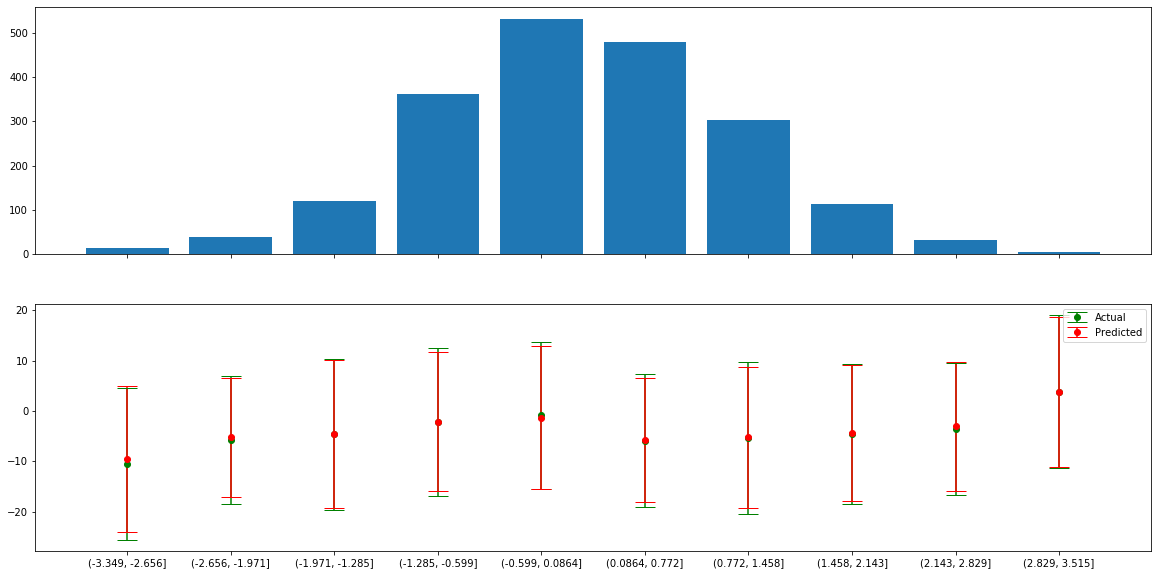

In [23]:
# x1
plot_univariate(df10, 'x1', 'y')

                 x2    n    y_mean       y_sd    p_mean       p_sd
0  (-3.279, -2.595]   11 -8.963161   8.915807 -8.914283   9.200884
1  (-2.595, -1.917]   51 -2.583432   9.656766 -2.862151   9.964255
2   (-1.917, -1.24]  148 -3.944287  12.748935 -3.911618  12.760124
3   (-1.24, -0.562]  324 -3.311579  16.481169 -3.165766  15.001846
4   (-0.562, 0.115]  516 -3.096149  15.152012 -3.129040  14.260187
5    (0.115, 0.793]  502 -4.007994  14.113056 -4.011922  13.331853
6    (0.793, 1.471]  308 -3.565381  13.985441 -3.564736  13.454049
7    (1.471, 2.148]  105 -6.141877  13.036458 -6.319921  12.668414
8    (2.148, 2.826]   29 -4.510177   8.878486 -4.519737   9.623531
9    (2.826, 3.503]    6  6.986870  13.642510  6.262652  13.826729


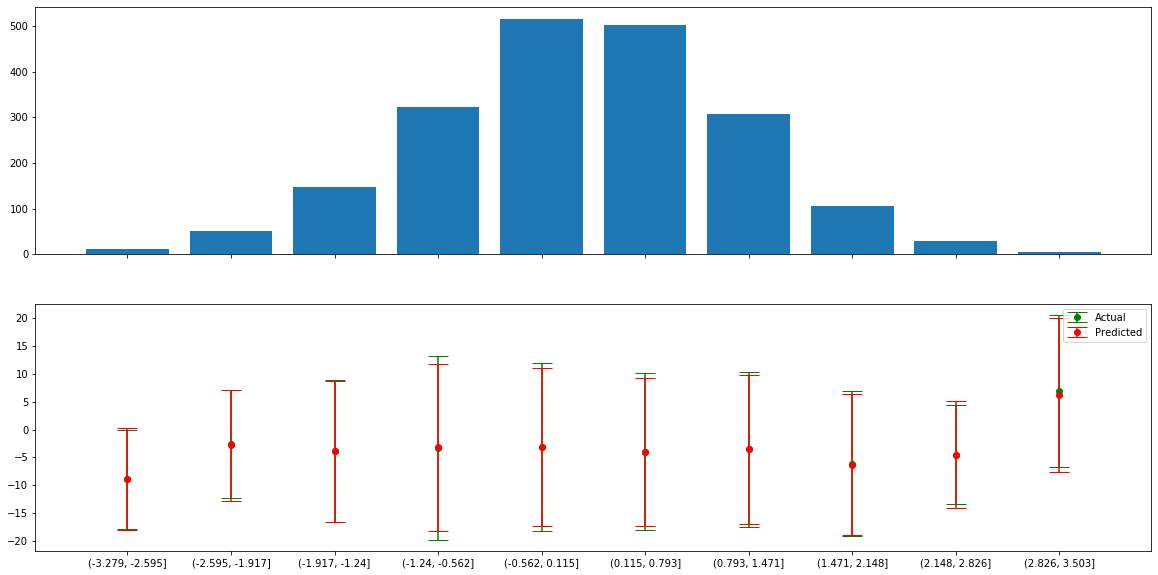

In [24]:
# x2
plot_univariate(df10, 'x2', 'y')

<ipython-input-22-aae3c8e7af56>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df10.x7 == filter_x7]


                 x2    n    y_mean       y_sd    p_mean       p_sd
0  (-3.271, -2.591]    5 -8.106606   8.415644 -6.175915   7.574198
1  (-2.591, -1.917]   24 -0.454520  10.475494  0.507666  10.704645
2  (-1.917, -1.243]   66  5.468557   9.691468  6.011194   9.321298
3  (-1.243, -0.569]  143  7.990921  12.138608  7.755416  10.289589
4   (-0.569, 0.105]  245  7.707951  12.060639  7.211477  11.270968
5    (0.105, 0.778]  226  7.482381   9.601512  6.757788   9.138538
6    (0.778, 1.452]  157  5.186901  10.571099  5.064702   9.977645
7    (1.452, 2.126]   53  2.455858  10.313153  2.322777   9.629354
8      (2.126, 2.8]    9 -5.622920   6.225904 -3.813785   6.854513
9      (2.8, 3.474]    3  4.351880  11.060596  5.652078  12.586432


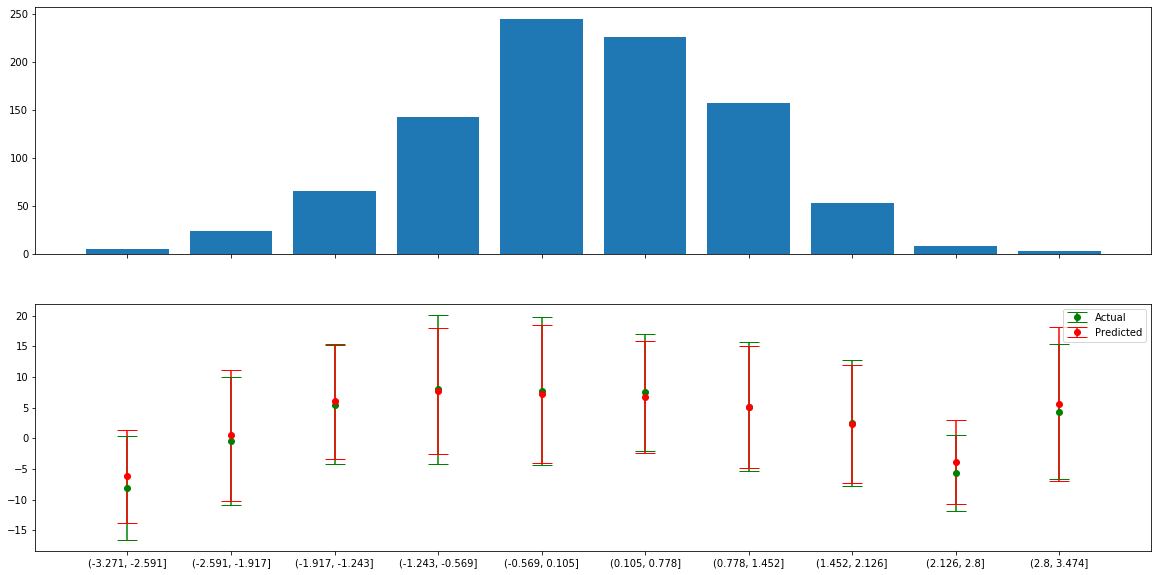

In [25]:
# x2 * x7 == A1
plot_univariate(df10, 'x2', 'y', filter_x7='A1')

<ipython-input-22-aae3c8e7af56>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df10.x7 == filter_x7]


                 x2    n     y_mean       y_sd     p_mean       p_sd
0  (-3.279, -2.595]    6  -9.676958  10.048865 -11.196256  10.472355
1  (-2.595, -1.917]   27  -4.475799   8.623015  -5.857545   8.352734
2   (-1.917, -1.24]   82 -11.520478   9.449803 -11.898272   8.997952
3   (-1.24, -0.562]  178 -12.621042  13.489726 -12.156180  11.984298
4   (-0.562, 0.115]  269 -13.150621   9.761618 -12.745833   8.948165
5    (0.115, 0.793]  279 -12.984273  10.235272 -12.422855   9.742291
6    (0.793, 1.471]  148 -13.208319  10.359310 -13.055355   9.802718
7    (1.471, 2.148]   57 -12.820662  11.315906 -13.097736  10.863147
8    (2.148, 2.826]   20  -4.009443   9.949655  -4.837416  10.786851
9    (2.826, 3.503]    3   9.621860  17.947949   6.873226  17.844030


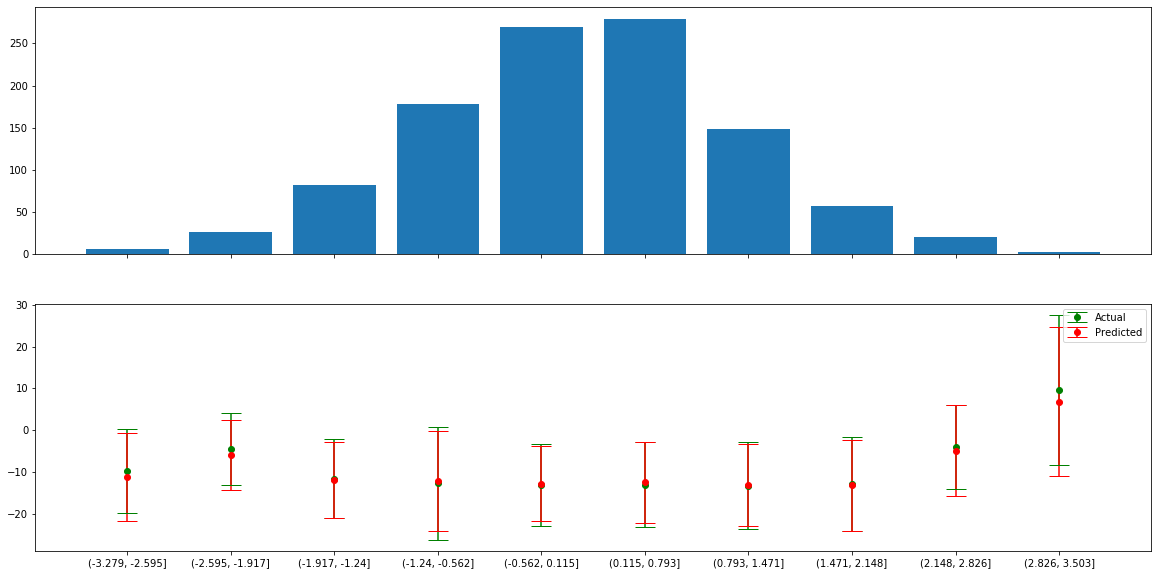

In [26]:
# x2 * x7 == A2
plot_univariate(df10, 'x2', 'y', filter_x7='A2')

                x3    n     y_mean       y_sd     p_mean       p_sd
0  (-0.323, 0.366]    9 -11.805981  10.815292 -10.349218  11.062031
1   (0.366, 1.048]   43  -0.902139  16.096326  -1.377566  15.611651
2    (1.048, 1.73]  165  -4.245541  13.734647  -4.316619  13.337277
3    (1.73, 2.412]  362  -2.600431  14.504536  -2.499251  13.563328
4   (2.412, 3.094]  530  -4.319000  14.038637  -4.193994  13.266472
5   (3.094, 3.776]  462  -3.946593  14.129089  -4.031877  13.499470
6   (3.776, 4.458]  288  -2.848500  15.211305  -3.018743  14.209131
7    (4.458, 5.14]  113  -3.893005  16.089874  -4.067913  15.174387
8    (5.14, 5.822]   25  -5.653557  14.065525  -4.886722  12.947009
9   (5.822, 6.504]    3  -9.220591  19.771726  -8.705508  18.573321


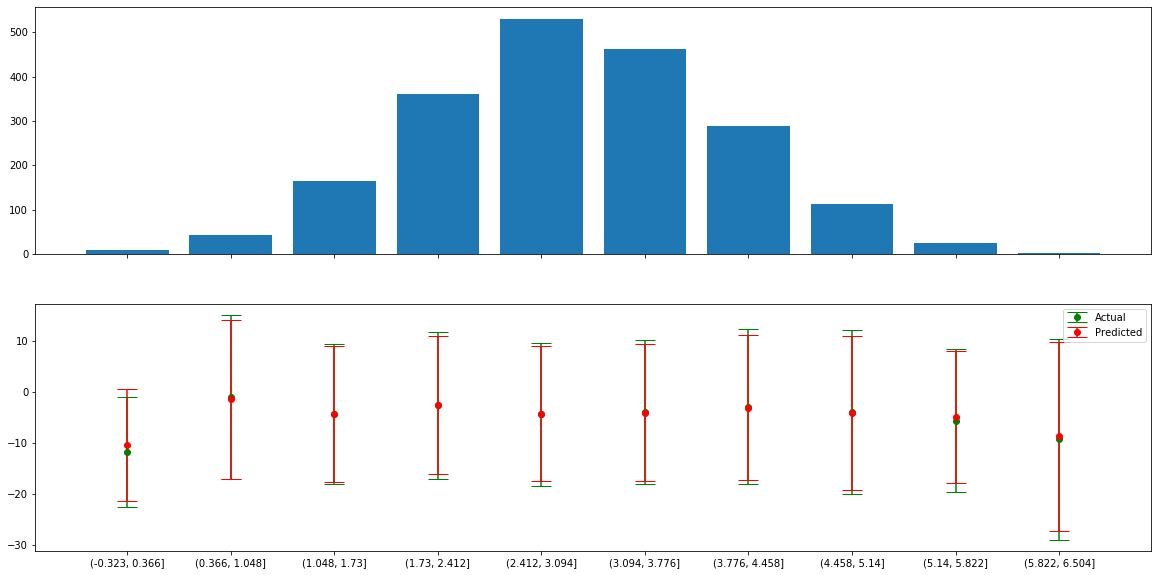

In [27]:
# x3
plot_univariate(df10, 'x3', 'y')

                 x4    n     y_mean       y_sd     p_mean       p_sd
0  (-3.336, -2.646]    6 -10.930331  12.006297 -10.826551  11.597405
1  (-2.646, -1.964]   37  -5.186150  19.615593  -4.889078  19.550376
2  (-1.964, -1.281]  136  -6.879913  13.236798  -6.687846  12.738097
3  (-1.281, -0.598]  358  -5.059908  15.377327  -4.902076  14.506372
4  (-0.598, 0.0847]  511  -4.743645  13.660591  -4.663711  12.960434
5   (0.0847, 0.767]  508  -2.253742  14.386944  -2.449549  13.516308
6     (0.767, 1.45]  305  -1.745711  14.430397  -1.469534  13.445424
7     (1.45, 2.133]  108  -1.684101  13.362159  -2.589855  12.928181
8    (2.133, 2.816]   23  -0.794036  15.371043  -1.105997  14.469688
9    (2.816, 3.499]    8  -2.814282  15.805801  -5.128429  15.288899


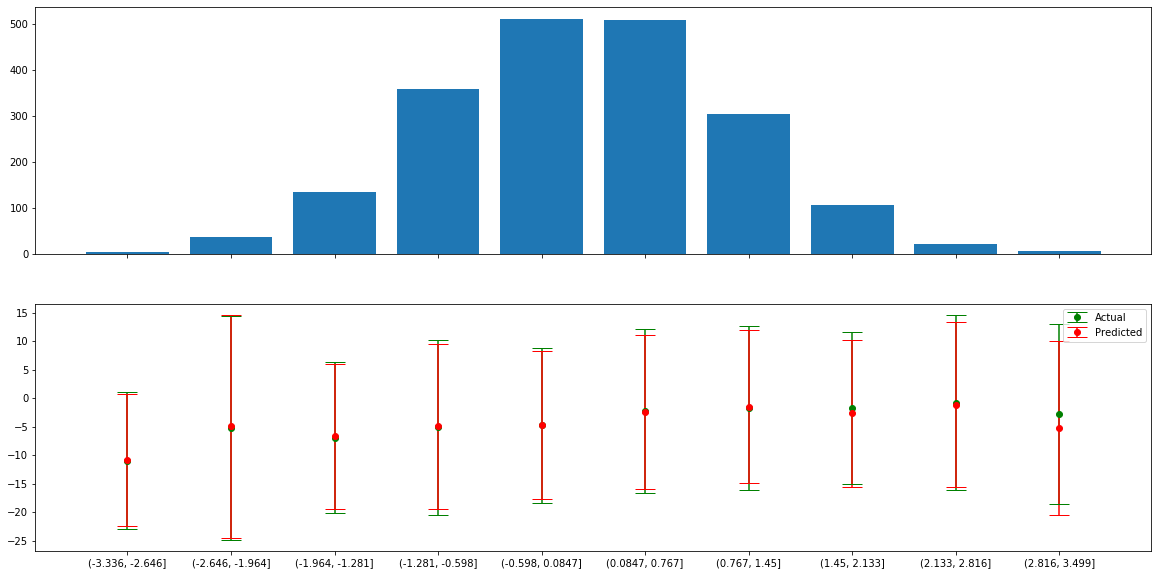

In [28]:
# x4
plot_univariate(df10, 'x4', 'y')

                 x5    n     y_mean       y_sd     p_mean       p_sd
0  (-3.852, -3.123]    2 -50.635420  13.284488 -31.215117   9.869207
1  (-3.123, -2.402]   19 -17.244148  13.685882 -17.056572  13.012156
2   (-2.402, -1.68]   89  -4.393372  12.563297  -3.999112  12.218124
3   (-1.68, -0.958]  215   0.895493  12.860241   0.160597  11.934174
4  (-0.958, -0.236]  502  -2.165445  13.036187  -2.383176  12.434452
5   (-0.236, 0.486]  558  -6.025738  13.261995  -5.963167  12.597916
6    (0.486, 1.207]  394  -7.183013  13.656944  -6.860210  13.012447
7    (1.207, 1.929]  177  -1.962756  15.046731  -1.996512  14.286321
8    (1.929, 2.651]   36  14.132880  15.216990  16.368095  13.072452
9    (2.651, 3.373]    8  52.118193  18.582697  45.812827  19.053700


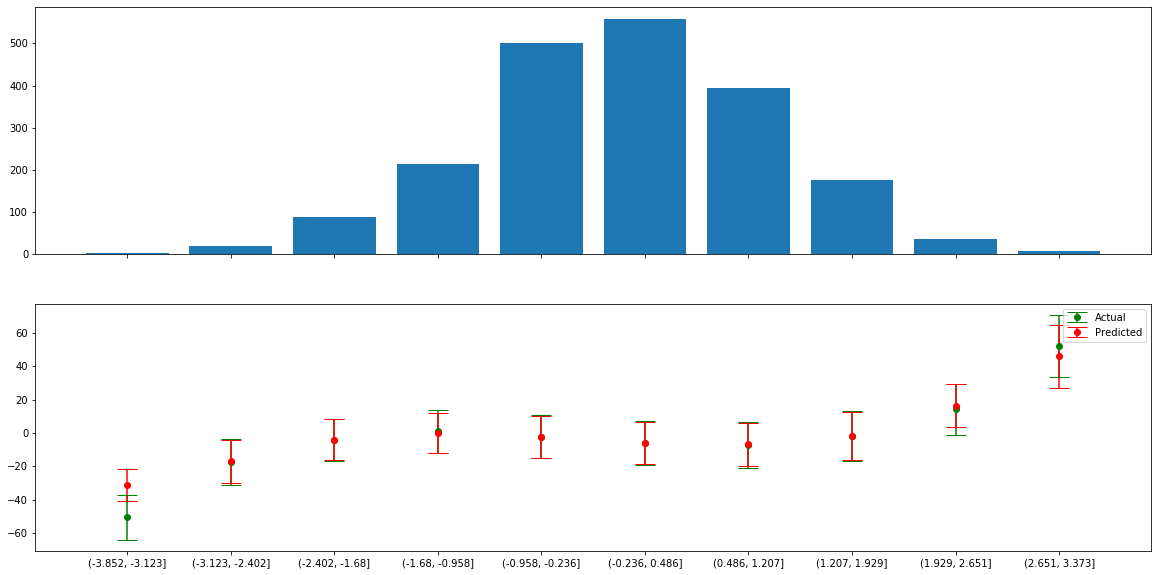

In [29]:
# x5
plot_univariate(df10, 'x5', 'y')

                 x6    n     y_mean       y_sd     p_mean       p_sd
0   (-0.968, 0.459]    6 -14.542230   4.385183 -12.313692   6.125445
1    (0.459, 1.871]   34   1.585852  15.082694   0.990531  14.608295
2    (1.871, 3.284]  146  -4.745006  14.198404  -4.946767  13.869473
3    (3.284, 4.697]  358  -3.081514  14.421713  -2.930795  13.568339
4    (4.697, 6.109]  523  -3.785036  14.272484  -3.744542  13.393278
5    (6.109, 7.522]  494  -4.211936  13.714992  -4.134486  13.125253
6    (7.522, 8.934]  298  -3.055536  15.420581  -3.330812  14.409512
7   (8.934, 10.347]  114  -3.306535  16.295409  -3.437662  15.433832
8  (10.347, 11.759]   24  -5.302985  13.386852  -4.628988  12.348536
9  (11.759, 13.172]    3  -8.088833  18.924234  -8.063540  18.141836


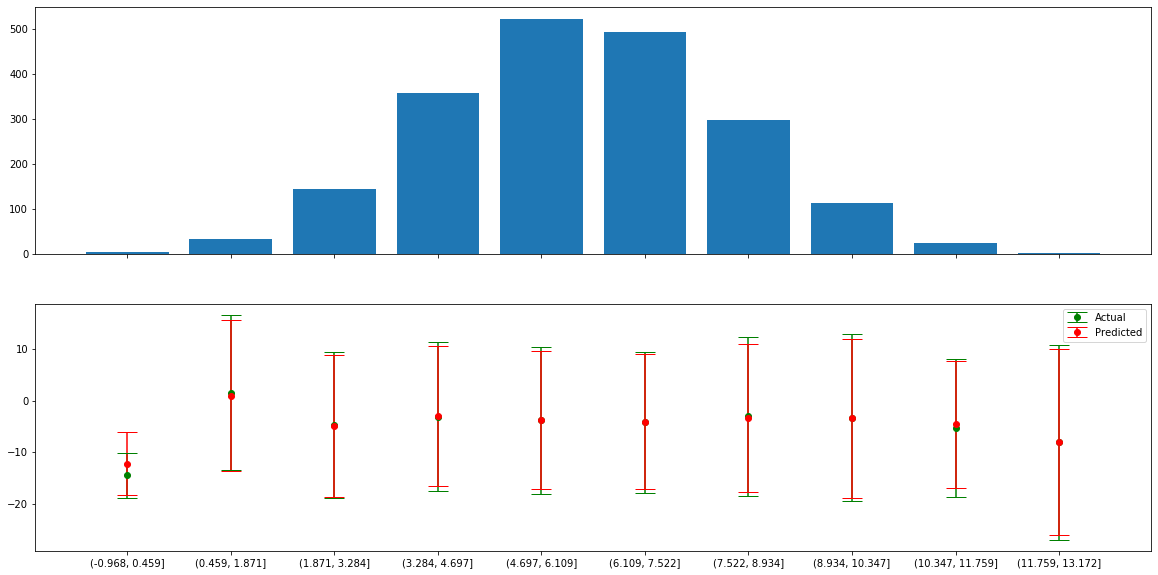

In [30]:
# x6
plot_univariate(df10, 'x6', 'y')

   x7     n     y_mean       y_sd     p_mean       p_sd
0  A1   931   6.378737  11.131655   6.103155  10.290673
1  A2  1069 -12.410846  10.906534 -12.174263  10.115934


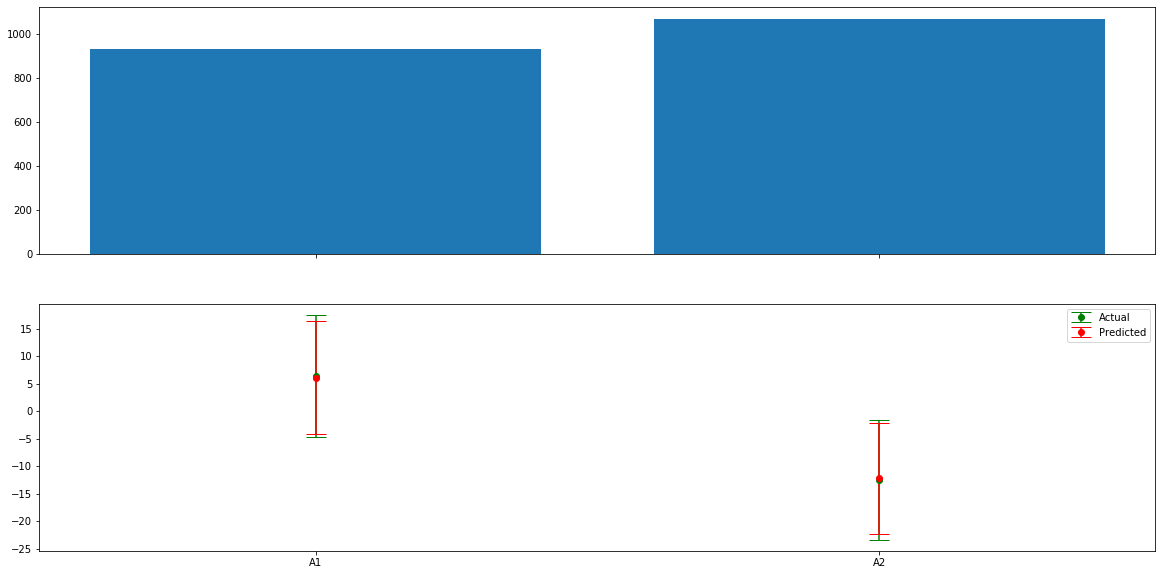

In [31]:
# x7
plot_univariate(df10, 'x7', 'y')

   x8    n    y_mean       y_sd    p_mean       p_sd
0  B1  408 -9.870796  14.827481 -9.642810  14.259926
1  B2  384 -9.155140  13.449646 -8.912077  12.511987
2  B3  439  0.319236  13.723353  0.091845  12.743286
3  B4  365 -0.198614  13.249155 -0.271993  12.510495
4  B5  404  0.362915  12.953490  0.205969  12.362484


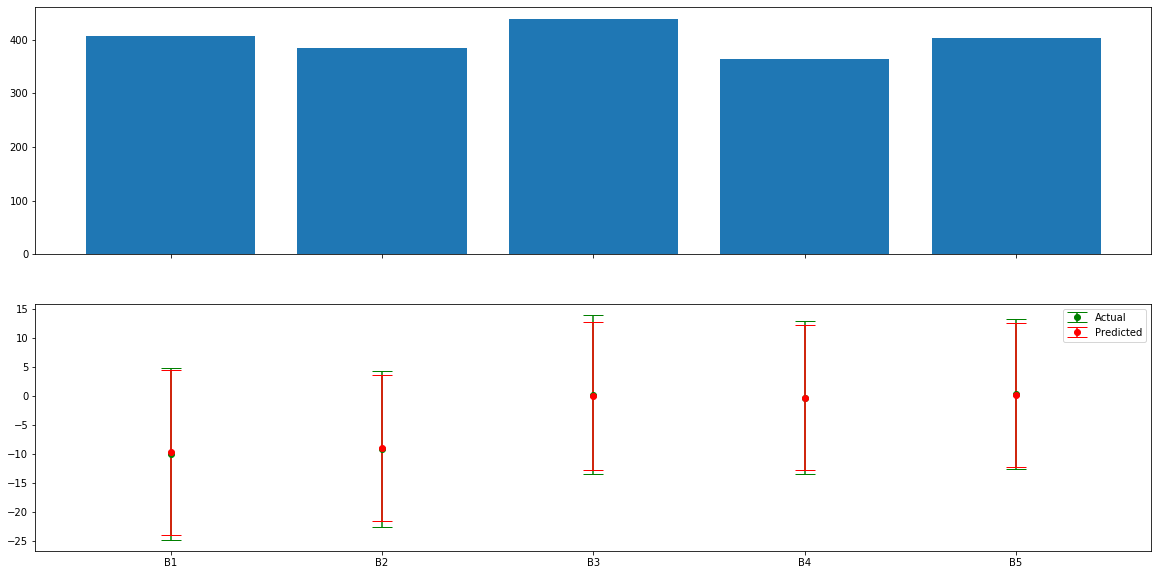

In [32]:
# x8
plot_univariate(df10, 'x8', 'y')

     x9   n     y_mean       y_sd     p_mean       p_sd
0    C0  44 -11.449154  11.865423 -12.501057  11.009257
1    C1  39  -7.403877  11.560906  -8.187850  10.473034
2   C10  41  -8.399086  15.627309  -8.362025  13.100187
3   C11  41  -8.086080  12.148196  -8.395156  11.517215
4   C12  42  -8.241409  12.543559  -8.276988  11.710282
5   C13  48  -2.180046  14.542123  -1.087623  12.177015
6   C14  44   3.727839  12.759579   3.605940  12.166269
7   C15  43 -12.738585  11.075329 -12.854326  10.466134
8   C16  47  -9.826713  11.958178 -10.131110  10.533316
9   C17  47  -3.939025  12.629985  -4.181953  11.787386
10  C18  51  -3.557728  10.818493  -2.567887  10.710277
11  C19  35   7.096602  12.006954   6.879736  11.472842
12   C2  34  -2.137282  12.039587  -2.425054  11.830290
13  C20  40 -11.236139  12.753242 -11.554245  12.846618
14  C21  34  -7.729983  14.700335  -7.960547  13.379225
15  C22  30  -8.004749  11.753302  -8.598272  11.629050
16  C23  25  -1.158287  11.773694  -0.899600  10

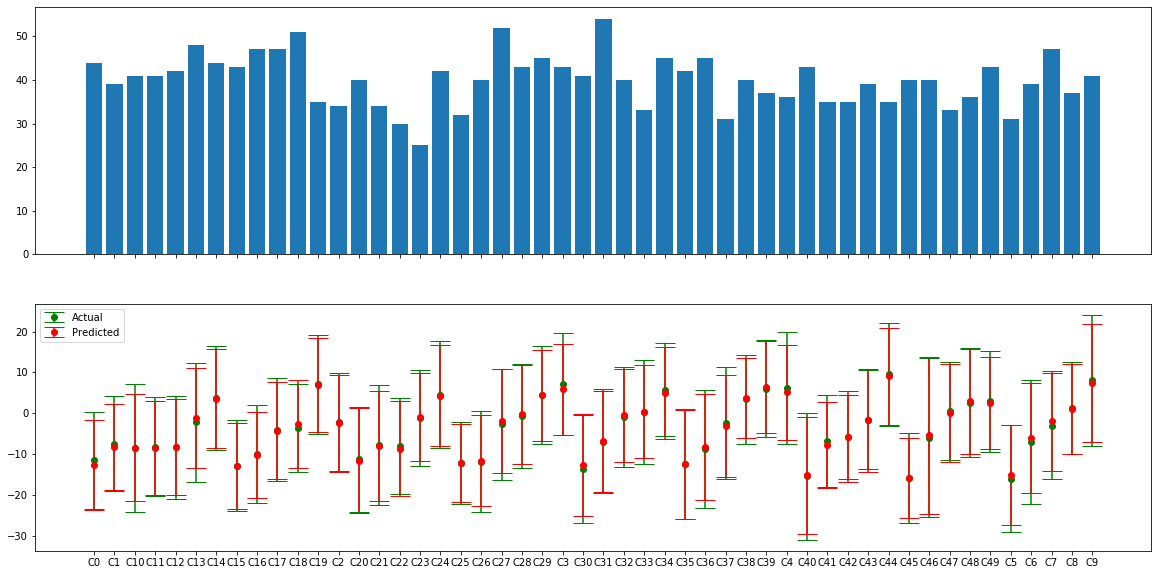

In [33]:
# x9
plot_univariate(df10, 'x9', 'y')

  x10    n    y_mean       y_sd    p_mean       p_sd
0  D1  421  0.256379  13.741910  0.012757  12.762855
1  D2  826 -0.427810  13.260177 -0.421308  12.540377
2  D3  753 -9.406580  14.293531 -9.282365  13.532480


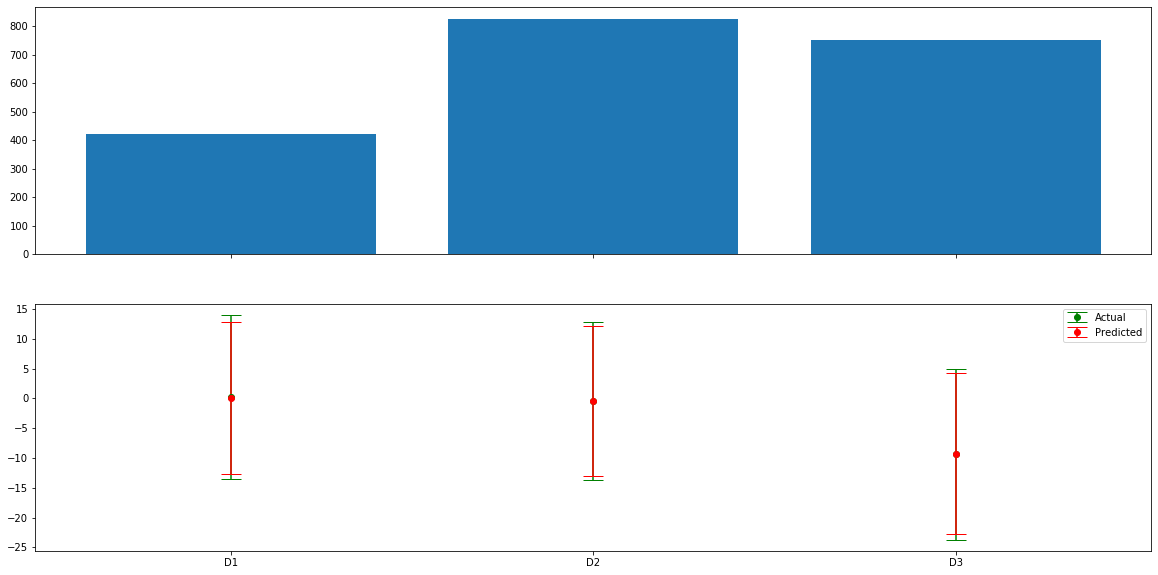

In [34]:
# x10
plot_univariate(df10, 'x10', 'y')

The only thing that really sticks out is relatively extreme x5 values, but we'd be affected ~10 rows by doing anything.  So let's leave the model as is.

# Evaluate on holdout

Let's evaluate all of our "best" hyperparameter sets to see how the holdout results compare to train/test results.

In [35]:
# Refit models on train and test data together
models_traintest = {}

for hp in best_hp_sets:
    print(f'Fitting {hp}')
    
    # Get train+test data
    X = X_train.append(X_test)
    y = y_train.append(y_test)
    
    # Fit gbm
    gbm = GradientBoostingRegressor(
        # Static hyperparameters
        n_estimators = s_n_estimators,
        validation_fraction = s_validation_fraction,
        n_iter_no_change = s_n_iter_no_change,
        tol = s_tol,
        # Dynamic hyperparameters
        max_depth = hp[0],
        max_features = hp[1],
        subsample = hp[2],
        # Print status
        verbose = 1
    ).fit(X, y)
    
    # Save predictions
    models_traintest[hp] = {
        'model': gbm,
        'err': y - gbm.predict(X),
        'holdout_err': y_holdout - gbm.predict(X_holdout)
    }
    
    del X, y, gbm

Fitting (3, 'auto', 0.75)
      Iter       Train Loss      OOB Improve   Remaining Time 
         1         180.6243          27.5903            8.99s
         2         159.7351          21.7152            9.48s
         3         144.5715          17.8488            9.31s
         4         129.8840          15.6377            9.21s
         5         110.7083          13.8427            9.15s
         6         102.9385          10.6881            8.95s
         7          94.6040           8.3275            8.94s
         8          87.4380           6.9241            8.93s
         9          79.3503           6.4554            8.92s
        10          70.5310           6.0272            8.91s
        20          41.3294           1.7151            8.72s
        30          28.0439           0.8659            8.70s
        40          19.7706           0.5417            8.57s
        50          15.9602           0.2971            8.51s
        60          13.0097           0.143

In [36]:
# Create df of train, test, train+test, and holdout performance for each best hyperparameter space
all_performance = dict()
for hp in best_hp_sets:
    all_performance[hp] = [
        amse(models_train_2[hp]['train_err']),
        amse(models_train_2[hp]['test_err']),
        amse(models_traintest[hp]['err']),
        amse(models_traintest[hp]['holdout_err']),
    ]
    
all_performance_df = pd.DataFrame.from_dict(
    all_performance,
    orient='index',
    columns=['train', 'test', 'train+test', 'holdout']
).reset_index()

all_performance_df

,index,train,test,train+test,holdout
0,"(3, auto, 0.75)",7.874551,9.835229,7.916452,10.615076
1,"(2, auto, 0.75)",9.821525,11.644296,8.907973,10.607091
2,"(4, auto, 0.75)",7.372642,10.521852,7.942670,12.936410
3,"(6, auto, 0.75)",7.116323,11.325699,6.202983,11.706489
4,"(3, log2, 0.67)",9.607912,11.980420,9.522963,14.193579
5,"(4, sqrt, 0.5)",9.223360,12.712888,8.232115,12.225926


In [37]:
# Melt for proper group bargraphing
all_performance_df_melt = pd.melt(all_performance_df, id_vars='index')

all_performance_df_melt

,index,variable,value
0,"(3, auto, 0.75)",train,7.874551
1,"(2, auto, 0.75)",train,9.821525
2,"(4, auto, 0.75)",train,7.372642
3,"(6, auto, 0.75)",train,7.116323
4,"(3, log2, 0.67)",train,9.607912
5,"(4, sqrt, 0.5)",train,9.223360
6,"(3, auto, 0.75)",test,9.835229
7,"(2, auto, 0.75)",test,11.644296
8,"(4, auto, 0.75)",test,10.521852
9,"(6, auto, 0.75)",test,11.325699


Text(0, 0.5, 'AMSE')

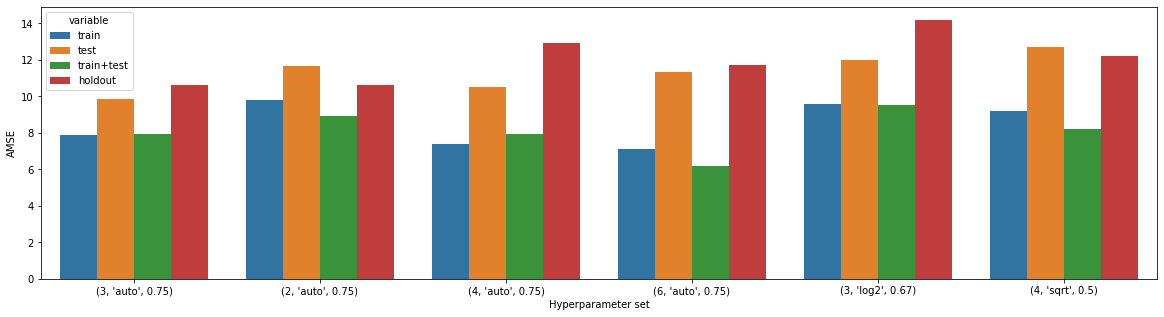

In [38]:
# Plot
plt.figure(figsize=(20, 5))
sb.barplot(
    data=all_performance_df_melt,
    x='index',
    y='value',
    hue='variable',
)
plt.xlabel('Hyperparameter set')
plt.ylabel('AMSE')

Text(0, 0.5, 'AMSE')

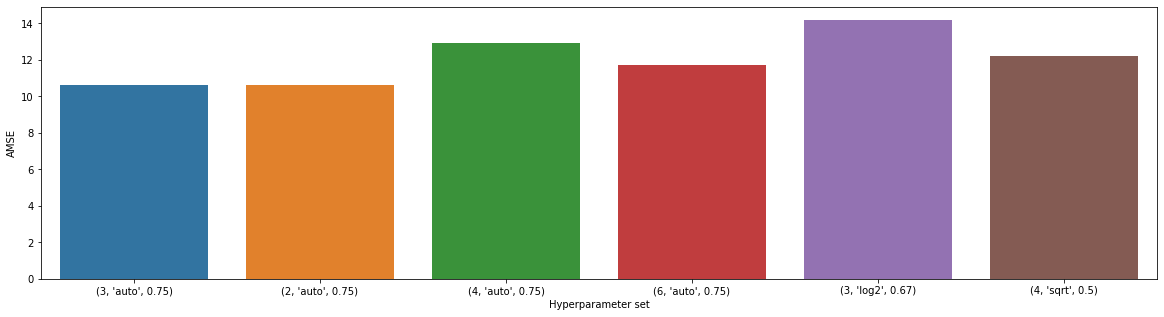

In [39]:
# Plot just holdout performance
plt.figure(figsize=(20, 5))
sb.barplot(
    data=all_performance_df_melt[all_performance_df_melt.variable == 'holdout'],
    x='index',
    y='value',
)
plt.xlabel('Hyperparameter set')
plt.ylabel('AMSE')

(3, auto, 0.75) seems like the best all-around fit:

- Second best performance on the test data and best performance on the holdout data
    - There's a lot of room for muddiness in picking between models that seem to be performing similarly, so "average" performance across test/holdout is something I usually use in making final decisions on which model to use
    - But, sometimes, the best thing to do is run multiple models in parallel in a "staging" type setup to see how they perform on new data and then make a final decision
- Similar performance on holdout set compared to test set
    - I generally index highly on having similar result in test/holdout unless there is a good reason for them to be different

Some other notes:

- (4, auto, 0.75) and (6, 'auto', 0.75) had the best performances on train-only and train/test-only data but worse performance on test and holdout (i.e. overfitting!)
    - As stated previously in the notebook, this is likely due to not having any sort of regularization (e.g. pruning, requiring a certain sample size) to balance tree complexity with accuracy
- The 'sqrt' and 'log' models don't do as well (they usually do right out of the box)
    - This is likely due to us restricting to only strong predictors at the outset, so when we sample those predictors we are excluding information that would likely be helpful